In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Data files/Special data files/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Data files/Special data files/test.csv")

In [3]:
x = train.drop(columns = "Survived")
y = train["Survived"]

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=0)

In [6]:
P_ID_test = test["PassengerId"]

In [7]:
# preprcoessing pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import IterativeImputer

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [9]:
x

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### Failed Pipeline (made all by me using previous notes)

In [11]:
# craete features: Family = SibSp + Parch, Farebin from Fare, Title from Name
# then drop SibSp, Parch, Name, Cabin
# Encode_Features = ["Embarked","Title","Sex","Ticket"] #for encoding
# Impute_Features = ["Age","Embarked"]

In [12]:
# Encoding_Pipeline = Pipeline(steps = [
#     ("Encoding", OrdinalEncoder(handle_unknown = 'Ignore'))
# ])
# Imputing_Pipeline = Pipeline(steps = [
#     ("Imputing", IterativeImputer)
# ])

In [13]:
# preprocessor = ColumnTransformer([
#     ("only_encode",Encode_Features,Encoding_Pipeline),
#     ("only_impute", Impute_Features, Imputing_Pipeline)
#                                  ])

In [14]:
# pipeline = Pipeline(steps=["Preprocessor",preprocessor])

### Pipeline made with help of ChatGPT

In [15]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import IterativeImputer

# 1. Feature Engineering

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # FamilySize
        X["FamilySize"] = X["SibSp"] + X["Parch"]

        # Title from Name
        X["Title"] = X["Name"].str.extract("([A-Za-z]+)\.", expand=False)

        # FareBin
        X["FareBin"] = pd.cut(
            X["Fare"],
            bins=[0, 14.45, 50, 100, 350],
            labels=["Very_Low", "Low", "Medium", "High"]
        )

        # Drop unnecessary columns
        X.drop(["Name", "SibSp", "Parch", "Cabin","PassengerId"], axis=1, inplace=True)

        return X


# 2. Column Lists

encode_features = ["Embarked", "Sex", "Title", "FareBin", "Ticket"]
impute_features = ["Age"]


# 3. Pipelines

encoding_pipeline = Pipeline(steps=[
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

imputing_pipeline = Pipeline(steps=[
    ("impute", IterativeImputer(random_state=42))
])

preprocessor = ColumnTransformer(transformers=[
    ("encode", encoding_pipeline, encode_features),
    ("impute", imputing_pipeline, impute_features)
], remainder="passthrough")  # Pass through other columns like 'Fare', 'FamilySize'


# 4. Full Pipeline (No model)

preprocessing_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor)
])


### Model and prediction

In [16]:
x_train_processed = preprocessing_pipeline.fit_transform(x_train)
x_test_processed = preprocessing_pipeline.transform(x_test)
x_train_processed

array([[ 2.    ,  1.    ,  9.    , ...,  1.    , 26.55  ,  0.    ],
       [ 0.    ,  0.    , 10.    , ...,  1.    , 76.7292,  1.    ],
       [ 2.    ,  1.    ,  5.    , ...,  3.    , 46.9   ,  7.    ],
       ...,
       [ 1.    ,  1.    ,  9.    , ...,  3.    ,  7.7333,  0.    ],
       [ 2.    ,  0.    , 10.    , ...,  3.    , 17.4   ,  1.    ],
       [ 2.    ,  1.    ,  9.    , ...,  2.    , 39.    ,  2.    ]])

In [17]:
test_preprocessed = preprocessing_pipeline.transform(test)

In [ ]:
pd.DataFrame(x_train_processed)

,0,1,2,3,4,5,6,7,8
0,2.0,1.0,9.0,1.0,18.0,51.000000,1.0,26.5500,0.0
1,0.0,0.0,10.0,2.0,438.0,49.000000,1.0,76.7292,1.0
2,2.0,1.0,5.0,1.0,420.0,1.000000,3.0,46.9000,7.0
3,2.0,1.0,9.0,2.0,313.0,54.000000,1.0,77.2875,1.0
4,0.0,0.0,10.0,1.0,157.0,29.915339,3.0,14.4583,1.0
...,...,...,...,...,...,...,...,...,...
618,0.0,0.0,6.0,2.0,455.0,39.000000,1.0,83.1583,2.0
619,2.0,0.0,6.0,3.0,306.0,19.000000,3.0,7.8542,1.0
620,1.0,1.0,9.0,3.0,217.0,29.915339,3.0,7.7333,0.0
621,2.0,0.0,10.0,1.0,230.0,36.000000,3.0,17.4000,1.0


In [ ]:
x

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 200)
model_1.fit(x_train_processed,y_train)
pred_1 = model_1.predict(x_test_processed)
accuracy_score(y_test,pred_1) #83.582%

0.835820895522388

In [ ]:
accuracy_score(y_train,model_1.predict(x_train_processed)) #99.839%

0.9983948635634029

In [ ]:
prediction_1 = model_1.predict(test_preprocessed)
result_1 = pd.DataFrame({
    "PassengerId":P_ID_test,
    "Survived":prediction_1
    })
result_1.to_csv("Random_Forest_Overfit_Pipeline.csv",header=True,index=False)

### Grid Search CV on Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = ({
    'n_estimators':[100,200,300],
    'max_depth':[None,1,3,5,7,9],
    'min_samples_split':[3,5,7],
    'max_features':['sqrt',0.75,1],
    'min_samples_leaf':[1,3,5,7],
})

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)


In [ ]:
grid_search.fit(x_train_processed,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 3, 5, 7, 9],
                         'max_features': ['sqrt', 0.75, 1],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [ ]:
print(f"grid_search.best_params_: {grid_search.best_params_}")
print(f"grid_search.best_estimator_: {grid_search.best_estimator_}")
print(f"grid_search.best_score_: {grid_search.best_score_}")
results = pd.DataFrame(grid_search.cv_results_)
print(f"grid_search.scorer_: {grid_search.scorer_}")
print(f"grid_search.n_splits_: {grid_search.n_splits_}")
sorted_results = results.sort_values(by='mean_test_score',ascending = False)
sorted_results

grid_search.best_params_: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
grid_search.best_estimator_: RandomForestClassifier(min_samples_split=5)
grid_search.best_score_: 0.8443612903225807
grid_search.scorer_: make_scorer(accuracy_score, response_method='predict')
grid_search.n_splits_: 5


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.310309,0.008426,0.016396,0.000409,None,sqrt,1,5,100,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.848,0.864,0.784,0.822581,0.903226,0.844361,0.039955,1
47,1.027410,0.022797,0.042221,0.001054,None,0.75,3,3,300,"{'max_depth': None, 'max_features': 0.75, 'min...",0.848,0.856,0.792,0.822581,0.887097,0.841135,0.032060,2
2,0.960809,0.012236,0.042835,0.000480,None,sqrt,1,3,300,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.816,0.880,0.808,0.806452,0.895161,0.841123,0.038372,3
482,1.673532,0.095478,0.074492,0.011168,7,0.75,3,5,300,"{'max_depth': 7, 'max_features': 0.75, 'min_sa...",0.856,0.840,0.792,0.822581,0.887097,0.839535,0.031876,4
377,1.020741,0.167202,0.040448,0.001752,5,0.75,3,7,300,"{'max_depth': 5, 'max_features': 0.75, 'min_sa...",0.840,0.840,0.816,0.814516,0.887097,0.839523,0.026239,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,1.097159,0.169728,0.051637,0.022130,1,1,7,5,300,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.680,0.672,0.680,0.709677,0.709677,0.690271,0.016112,644
189,0.410762,0.030222,0.025393,0.005031,1,1,3,3,100,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.664,0.632,0.680,0.717742,0.750000,0.688748,0.041235,645
183,0.248646,0.011777,0.013880,0.000615,1,1,1,5,100,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.688,0.688,0.656,0.709677,0.701613,0.688658,0.018314,646
180,0.250277,0.015374,0.015124,0.000996,1,1,1,3,100,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.672,0.688,0.680,0.661290,0.733871,0.687032,0.025031,647


In [ ]:
# prompt: Using dataframe sorted_results: suggest a plot

import altair as alt

# Create a scatter plot of mean_test_score vs. mean_fit_time, colored by param_n_estimators
chart = alt.Chart(sorted_results).mark_circle().encode(
    x='param_max_depth',
    y='mean_test_score',
    color='param_n_estimators:N',
    tooltip=['params', 'mean_test_score', 'mean_fit_time', 'param_n_estimators']
).interactive()

chart


alt.Chart(...)

### Testing Grid Search

In [ ]:
model_2 = grid_search
# model_2.fit(x_train_processed,y_train)
accuracy_score(y_test,model_2.predict(x_test_processed)) #grid_search best 83.582% on cv

0.835820895522388

In [ ]:
accuracy_score(y_train,model_2.predict(x_train_processed)) #95.184% train accuracy, kinda overfit

0.9518459069020867

In [ ]:
model_2 = RandomForestClassifier(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split =  5, n_estimators = 100)

In [ ]:
from sklearn.model_selection import learning_curve
learning_curve(model_2,x_train_processed,y_train,scoring='accuracy',verbose=3,n_jobs=-1)

[learning_curve] Training set sizes: [ 49 161 273 385 498]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.5s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    8.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.7s finished


(array([ 49, 161, 273, 385, 498]),
 array([[0.93877551, 0.97959184, 0.95918367, 0.97959184, 0.97959184],
        [0.97515528, 0.94409938, 0.96273292, 0.95652174, 0.95031056],
        [0.97069597, 0.96703297, 0.95238095, 0.95970696, 0.95238095],
        [0.96363636, 0.95584416, 0.95324675, 0.95324675, 0.96103896],
        [0.94779116, 0.94578313, 0.96184739, 0.96385542, 0.95983936]]),
 array([[0.776     , 0.84      , 0.768     , 0.77419355, 0.82258065],
        [0.8       , 0.856     , 0.776     , 0.80645161, 0.83870968],
        [0.816     , 0.888     , 0.824     , 0.81451613, 0.87096774],
        [0.824     , 0.864     , 0.784     , 0.7983871 , 0.85483871],
        [0.832     , 0.864     , 0.792     , 0.7983871 , 0.87903226]]))

[learning_curve] Training set sizes: [ 49 161 273 385 498]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    2.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    7.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.8s finished


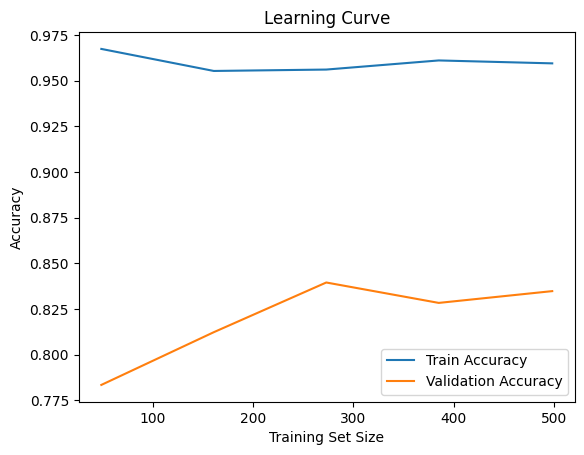

In [ ]:
import matplotlib.pyplot as plt
learning_curve(model_2,x_train_processed,y_train,scoring='accuracy',verbose=3,n_jobs=-1)
train_sizes, train_scores, val_scores = learning_curve(
    model_2, x_train_processed, y_train, scoring='accuracy', verbose=3, n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


### Custom Architectures

In [ ]:
accuracy_score(y_train,((RandomForestClassifier(max_depth = 7, max_features = 'sqrt', min_samples_leaf = 3, min_samples_split =  5, n_estimators = 100)).fit(x_train_processed,y_train)).predict(x_train_processed))
#with max_depth = 7 and min samples leaf 3 to prevent over fitting, cv score = 83.95, train score = 88.764%

0.8876404494382022

In [ ]:
accuracy_score(y_train,((RandomForestClassifier(max_depth = 3, max_features = 1/1.71 , min_samples_leaf = 4, min_samples_split =  5, n_estimators = 100)).fit(x_train_processed,y_train)).predict(x_train_processed))
# max_features = 1/1.71 (1/root 3), max_depth = 3, min samples leaf = 4, cv = 81.716, train = 82.985

0.8298555377207063

In [ ]:
# now ill make fresh models using grid search features and these regularized features and predict on leaderbaord

### Fresh Models

In [ ]:
m1 = RandomForestClassifier(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split =  5, n_estimators = 100)
predictions = (m1.fit(x_train_processed,y_train)).predict(test_preprocessed)
r1 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r1.to_csv("RF_Grid_Search_CV_Overfit.csv",header=True,index=False)  #leaderboard score = 75.119 , 95.184% train , 83.582% on cv

In [ ]:
m2 = RandomForestClassifier(max_depth = 7, max_features = 'sqrt', min_samples_leaf = 3, min_samples_split =  5, n_estimators = 100)
predictions = (m2.fit(x_train_processed,y_train)).predict(test_preprocessed)
r2 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r2.to_csv("RF_Modified_from_Grid_Search.csv",header=True,index=False)  #leaderboard score = 76.076,cv score = 83.95, train score = 88.764%

In [ ]:
m3 = RandomForestClassifier(max_depth = 3, max_features = 1/1.71, min_samples_leaf = 4, min_samples_split =  5, n_estimators = 100)
predictions = (m3.fit(x_train_processed,y_train)).predict(test_preprocessed)
r3 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r3.to_csv("RF_Modified1.csv",header=True,index=False)  #leaderboard score = 78.229(i fitted m2 by mistaeke), cv = 81.716, train = 82.985, new leaderboard score 78.708

In [ ]:
m4 = RandomForestClassifier(max_depth = 4, max_features = 1/1.71, min_samples_leaf = 3, min_samples_split =  5, n_estimators = 200) #slightly overfitting
predictions = (m4.fit(x_train_processed,y_train)).predict(test_preprocessed)
r4 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r4.to_csv("RF_Modified2.csv",header=True,index=False) #78.468 on leaderboard

In [ ]:
from xgboost import XGBClassifier
m5 = XGBClassifier() #using vanilla xgboost
predictions = (m5.fit(x_train_processed,y_train)).predict(test_preprocessed)
r5 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r5.to_csv("XGB_High_Feature_Eng.csv",header=True,index=False) #68.660 on leaderboard

In [18]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
m6 = CatBoostClassifier() #using vanilla catboost
predictions = (m6.fit(x_train_processed,y_train)).predict(test_preprocessed)
r6 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r6.to_csv("CatBoost_High_Feature_Eng.csv",header=True,index=False) #74.880

Learning rate set to 0.008417
0:	learn: 0.6874697	total: 52.8ms	remaining: 52.8s
1:	learn: 0.6828540	total: 54ms	remaining: 26.9s
2:	learn: 0.6798085	total: 57.5ms	remaining: 19.1s
3:	learn: 0.6747855	total: 59.2ms	remaining: 14.8s
4:	learn: 0.6694066	total: 68.6ms	remaining: 13.7s
5:	learn: 0.6641201	total: 80.2ms	remaining: 13.3s
6:	learn: 0.6599091	total: 88.5ms	remaining: 12.6s
7:	learn: 0.6549858	total: 96.2ms	remaining: 11.9s
8:	learn: 0.6511900	total: 98ms	remaining: 10.8s
9:	learn: 0.6457443	total: 110ms	remaining: 10.9s
10:	learn: 0.6416865	total: 117ms	remaining: 10.5s
11:	learn: 0.6382865	total: 118ms	remaining: 9.69s
12:	learn: 0.6338460	total: 129ms	remaining: 9.76s
13:	learn: 0.6291589	total: 132ms	remaining: 9.33s
14:	learn: 0.6251492	total: 139ms	remaining: 9.13s
15:	learn: 0.6210394	total: 145ms	remaining: 8.92s
16:	learn: 0.6174821	total: 147ms	remaining: 8.49s
17:	learn: 0.6150346	total: 157ms	remaining: 8.59s
18:	learn: 0.6105315	total: 159ms	remaining: 8.22s
19:	le

### Grid Search on Boosted Trees

In [ ]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5]
}


xgb = XGBClassifier()
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3)
grid.fit(x_train_processed, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.816 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.824 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.808 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.806 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.839 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8;, score=0.824 total time=   0.3s
[CV 2/5] END colsamp

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 5], 'n_estimators': [100, 300],
                         'subsample': [0.8]},
             scoring='accuracy', verbose=3)

In [ ]:
print(f"grid_search.best_params_: {grid.best_params_}")
print(f"grid_search.best_estimator_: {grid.best_estimator_}")
print(f"grid_search.best_score_: {grid.best_score_}")
results = pd.DataFrame(grid.cv_results_)
print(f"grid_search.scorer_: {grid.scorer_}")
print(f"grid_search.n_splits_: {grid.n_splits_}")
sorted_results = results.sort_values(by='mean_test_score',ascending = False)
sorted_results

grid_search.best_params_: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
grid_search.best_estimator_: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
grid_search.best_score_: 0.8315096774193549
grid_search.scorer_: mak

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.066505,0.002977,0.004919,0.000401,0.8,0.05,7,1,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.824,0.856,0.784,0.830645,0.862903,0.831510,0.027927,1
4,0.057846,0.015156,0.004366,0.000292,0.8,0.05,5,1,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.840,0.840,0.784,0.830645,0.854839,0.829897,0.024221,2
25,0.084470,0.003671,0.004270,0.000438,1.0,0.05,3,1,300,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.840,0.872,0.776,0.830645,0.830645,0.829858,0.030922,3
16,0.049206,0.004026,0.005729,0.002958,0.8,0.10,5,1,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.816,0.864,0.776,0.830645,0.854839,0.828297,0.031212,4
1,0.427669,0.337268,0.009998,0.006089,0.8,0.05,3,1,300,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.824,0.872,0.776,0.830645,0.838710,0.828271,0.030911,5
13,0.081173,0.001836,0.003990,0.000235,0.8,0.10,3,1,300,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.800,0.872,0.784,0.838710,0.838710,0.826684,0.031231,6
32,0.076667,0.011116,0.005420,0.002088,1.0,0.05,7,1,100,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.816,0.856,0.784,0.822581,0.854839,0.826684,0.026852,7
29,0.223774,0.153110,0.006515,0.002604,1.0,0.05,5,1,300,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.808,0.880,0.776,0.822581,0.846774,0.826671,0.035160,8
28,0.338807,0.156314,0.009930,0.007269,1.0,0.05,5,1,100,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.816,0.840,0.784,0.830645,0.854839,0.825097,0.024121,9
20,0.059974,0.003470,0.003841,0.000109,0.8,0.10,7,1,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.808,0.856,0.792,0.838710,0.830645,0.825071,0.022622,10


In [ ]:
mod_1 = XGBClassifier(colsample_bytree = 0.8, learning_rate= 0.05, max_depth= 7, min_child_weight= 1, n_estimators =  100, subsample = 0.8)
mod_1.fit(x_train_processed,y_train)
accuracy_score(y_test,mod_1.predict(x_test_processed)) #cv 85.82, train 93.73

0.8582089552238806

In [ ]:
accuracy_score(y_train,mod_1.predict(x_train_processed))

0.9373996789727127

[learning_curve] Training set sizes: [ 49 161 273 385 498]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    3.0s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.1s finished


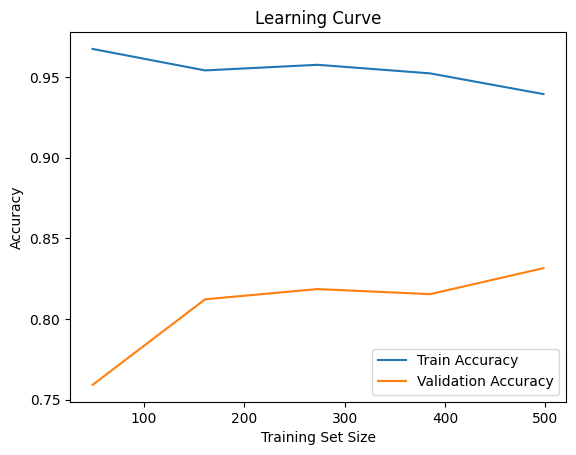

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    mod_1, x_train_processed, y_train, scoring='accuracy', verbose=3, n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [ ]:
predictions = mod_1.predict(test_preprocessed)
r_mod_1 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
r_mod_1.to_csv("Tuned_XGB.csv",header=True,index=False) #75.511 leaderboard

### Training the best model till now with total dataset (train+cv)

In [21]:
full_train = preprocessing_pipeline.fit_transform(x)
full_test = y
test_processed = preprocessing_pipeline.transform(test)

In [22]:
test_processed

array([[ 1.    ,  1.    , 12.    , ...,  3.    ,  7.8292,  0.    ],
       [ 2.    ,  0.    , 13.    , ...,  3.    ,  7.    ,  1.    ],
       [ 1.    ,  1.    , 12.    , ...,  2.    ,  9.6875,  0.    ],
       ...,
       [ 2.    ,  1.    , 12.    , ...,  3.    ,  7.25  ,  0.    ],
       [ 2.    ,  1.    , 12.    , ...,  3.    ,  8.05  ,  0.    ],
       [ 0.    ,  1.    ,  8.    , ...,  3.    , 22.3583,  2.    ]])

In [24]:
from sklearn.ensemble import RandomForestClassifier
n1 = RandomForestClassifier(max_depth = 3, max_features = 1/1.71, min_samples_leaf = 4, min_samples_split =  5, n_estimators = 100)
predictions = (n1.fit(full_train,y)).predict(test_processed)
rn1 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn1.to_csv("RF_Modified1_on_full_training_data.csv",header=True,index=False) #78.229 on leaderboard

### Catboost and Grid Search CV

In [32]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'iterations': [150, 350],
    'depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bylevel': [0.8, 1.0],
    'l2_leaf_reg':[1,3,5]
}


n2 = CatBoostClassifier()
grid = GridSearchCV(estimator=n2, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
grid.fit(x_train_processed, y_train)

Streaming output truncated to the last 5000 lines.
264:	learn: 0.0928766	total: 272ms	remaining: 87.2ms
265:	learn: 0.0923617	total: 273ms	remaining: 86.2ms
266:	learn: 0.0919637	total: 274ms	remaining: 85.1ms
267:	learn: 0.0915490	total: 275ms	remaining: 84.1ms
268:	learn: 0.0912651	total: 276ms	remaining: 83ms
269:	learn: 0.0904561	total: 277ms	remaining: 82ms
270:	learn: 0.0900666	total: 278ms	remaining: 80.9ms
271:	learn: 0.0896886	total: 279ms	remaining: 79.9ms
272:	learn: 0.0894524	total: 280ms	remaining: 78.9ms
273:	learn: 0.0888626	total: 281ms	remaining: 77.8ms
274:	learn: 0.0881763	total: 282ms	remaining: 76.8ms
275:	learn: 0.0879581	total: 283ms	remaining: 75.8ms
276:	learn: 0.0878278	total: 284ms	remaining: 74.7ms
277:	learn: 0.0875852	total: 285ms	remaining: 73.7ms
278:	learn: 0.0872090	total: 286ms	remaining: 72.7ms
279:	learn: 0.0870933	total: 286ms	remaining: 71.6ms
280:	learn: 0.0869046	total: 287ms	remaining: 70.6ms
281:	learn: 0.0867452	total: 288ms	remaining: 69.6ms

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc740f2c490>,
             param_grid={'colsample_bylevel': [0.8, 1.0], 'depth': [3, 5, 7],
                         'iterations': [150, 350], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=2)

In [36]:
from sklearn.metrics import accuracy_score as accuracy
accuracy(y_train,grid.predict(x_train_processed))

0.9470304975922953

In [33]:
print(f"grid_search.best_params_: {grid.best_params_}")
print(f"grid_search.best_estimator_: {grid.best_estimator_}")
print(f"grid_search.best_score_: {grid.best_score_}")
results = pd.DataFrame(grid.cv_results_)
print(f"grid_search.scorer_: {grid.scorer_}")
print(f"grid_search.n_splits_: {grid.n_splits_}")
sorted_results = results.sort_values(by='mean_test_score',ascending = False)
sorted_results

grid_search.best_params_: {'colsample_bylevel': 0.8, 'depth': 3, 'iterations': 350, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'subsample': 0.8}
grid_search.best_estimator_: <catboost.core.CatBoostClassifier object at 0x7fc7421ffd10>
grid_search.best_score_: 0.8475096774193549
grid_search.scorer_: make_scorer(accuracy_score, response_method='predict')
grid_search.n_splits_: 5


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,0.181563,0.004064,0.001956,0.000053,0.8,3,350,3,0.10,0.8,"{'colsample_bylevel': 0.8, 'depth': 3, 'iterat...",0.848,0.872,0.824,0.830645,0.862903,0.847510,0.018298,1
140,0.192408,0.006093,0.001966,0.000029,1.0,3,350,5,0.10,0.8,"{'colsample_bylevel': 1.0, 'depth': 3, 'iterat...",0.832,0.880,0.832,0.822581,0.862903,0.845897,0.021827,2
168,0.337296,0.108965,0.002897,0.001690,1.0,5,350,3,0.05,0.8,"{'colsample_bylevel': 1.0, 'depth': 5, 'iterat...",0.848,0.872,0.816,0.814516,0.870968,0.844297,0.025220,3
33,0.177133,0.009606,0.002004,0.000106,0.8,3,350,5,0.10,1.0,"{'colsample_bylevel': 0.8, 'depth': 3, 'iterat...",0.832,0.872,0.816,0.822581,0.862903,0.841097,0.022298,4
66,0.241534,0.004943,0.002073,0.000200,0.8,5,350,5,0.05,0.8,"{'colsample_bylevel': 0.8, 'depth': 5, 'iterat...",0.832,0.872,0.816,0.822581,0.862903,0.841097,0.022298,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.407745,0.008252,0.002160,0.000082,1.0,7,350,3,0.10,0.8,"{'colsample_bylevel': 1.0, 'depth': 7, 'iterat...",0.792,0.808,0.816,0.814516,0.830645,0.812232,0.012536,212
106,0.398435,0.012340,0.002184,0.000192,0.8,7,350,5,0.20,0.8,"{'colsample_bylevel': 0.8, 'depth': 7, 'iterat...",0.808,0.824,0.800,0.798387,0.830645,0.812206,0.012936,213
203,0.409093,0.005408,0.002197,0.000112,1.0,7,350,1,0.20,1.0,"{'colsample_bylevel': 1.0, 'depth': 7, 'iterat...",0.784,0.832,0.800,0.798387,0.838710,0.810619,0.021058,214
95,0.398027,0.012453,0.002183,0.000131,0.8,7,350,1,0.20,1.0,"{'colsample_bylevel': 0.8, 'depth': 7, 'iterat...",0.808,0.832,0.800,0.798387,0.814516,0.810581,0.012178,215


In [35]:
# training the best catboost on whole training data and predicitng on leaderboard

n3 = CatBoostClassifier(colsample_bylevel = 0.8, depth= 3, iterations = 350, l2_leaf_reg= 3, learning_rate= 0.1, subsample= 0.8)
predictions = (n3.fit(full_train,y)).predict(test_processed)
rn3 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn3.to_csv("tuned_catboost_on_full_data.csv",header=True,index=False)

0:	learn: 0.6454582	total: 815us	remaining: 285ms
1:	learn: 0.5997979	total: 1.4ms	remaining: 243ms
2:	learn: 0.5647760	total: 1.98ms	remaining: 229ms
3:	learn: 0.5390390	total: 3.99ms	remaining: 346ms
4:	learn: 0.5227592	total: 8.1ms	remaining: 559ms
5:	learn: 0.5038745	total: 8.75ms	remaining: 502ms
6:	learn: 0.4916093	total: 9.4ms	remaining: 461ms
7:	learn: 0.4779262	total: 10ms	remaining: 429ms
8:	learn: 0.4686615	total: 13.6ms	remaining: 514ms
9:	learn: 0.4642538	total: 14.2ms	remaining: 483ms
10:	learn: 0.4599194	total: 14.8ms	remaining: 458ms
11:	learn: 0.4511263	total: 17.9ms	remaining: 505ms
12:	learn: 0.4440130	total: 18.6ms	remaining: 482ms
13:	learn: 0.4372366	total: 21.3ms	remaining: 512ms
14:	learn: 0.4345728	total: 21.9ms	remaining: 490ms
15:	learn: 0.4292582	total: 24.5ms	remaining: 512ms
16:	learn: 0.4254864	total: 25.3ms	remaining: 495ms
17:	learn: 0.4221751	total: 26ms	remaining: 479ms
18:	learn: 0.4181681	total: 26.7ms	remaining: 465ms
19:	learn: 0.4165184	total: 27

In [38]:
accuracy(y,(n3.fit(full_train,y)).predict(full_train)) # leaderboard 74.88, train 93.93 , this bastard is overfitted

0:	learn: 0.6454582	total: 779us	remaining: 272ms
1:	learn: 0.5997979	total: 2.81ms	remaining: 489ms
2:	learn: 0.5647760	total: 3.48ms	remaining: 403ms
3:	learn: 0.5390390	total: 4.04ms	remaining: 350ms
4:	learn: 0.5227592	total: 6.87ms	remaining: 474ms
5:	learn: 0.5038745	total: 8.42ms	remaining: 483ms
6:	learn: 0.4916093	total: 10.2ms	remaining: 502ms
7:	learn: 0.4779262	total: 10.9ms	remaining: 465ms
8:	learn: 0.4686615	total: 11.4ms	remaining: 432ms
9:	learn: 0.4642538	total: 12ms	remaining: 407ms
10:	learn: 0.4599194	total: 17ms	remaining: 524ms
11:	learn: 0.4511263	total: 17.7ms	remaining: 497ms
12:	learn: 0.4440130	total: 18.2ms	remaining: 472ms
13:	learn: 0.4372366	total: 21.9ms	remaining: 524ms
14:	learn: 0.4345728	total: 23.6ms	remaining: 526ms
15:	learn: 0.4292582	total: 26.2ms	remaining: 547ms
16:	learn: 0.4254864	total: 27.5ms	remaining: 538ms
17:	learn: 0.4221751	total: 28.1ms	remaining: 519ms
18:	learn: 0.4181681	total: 32ms	remaining: 557ms
19:	learn: 0.4165184	total: 4

0.9393939393939394

In [39]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'iterations': [150, 350],
    'depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bylevel': [0.8, 1.0],
    'l2_leaf_reg':[1,3,5]
}


n = CatBoostClassifier()
grid = GridSearchCV(estimator=n, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
grid.fit(full_train, y) #on full dataset

Streaming output truncated to the last 5000 lines.
64:	learn: 0.2457183	total: 64.4ms	remaining: 282ms
65:	learn: 0.2439753	total: 65.5ms	remaining: 282ms
66:	learn: 0.2415787	total: 66.6ms	remaining: 281ms
67:	learn: 0.2415069	total: 67.1ms	remaining: 278ms
68:	learn: 0.2403677	total: 68.2ms	remaining: 278ms
69:	learn: 0.2394652	total: 69.2ms	remaining: 277ms
70:	learn: 0.2384516	total: 70.3ms	remaining: 276ms
71:	learn: 0.2374618	total: 71.4ms	remaining: 276ms
72:	learn: 0.2358631	total: 72.4ms	remaining: 275ms
73:	learn: 0.2352302	total: 73.5ms	remaining: 274ms
74:	learn: 0.2330444	total: 74.6ms	remaining: 273ms
75:	learn: 0.2300420	total: 75.6ms	remaining: 273ms
76:	learn: 0.2299186	total: 76.7ms	remaining: 272ms
77:	learn: 0.2285453	total: 77.7ms	remaining: 271ms
78:	learn: 0.2269249	total: 78.7ms	remaining: 270ms
79:	learn: 0.2253049	total: 79.8ms	remaining: 269ms
80:	learn: 0.2230828	total: 80.8ms	remaining: 268ms
81:	learn: 0.2223951	total: 81.9ms	remaining: 268ms
82:	learn: 0.

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc7407d48d0>,
             param_grid={'colsample_bylevel': [0.8, 1.0], 'depth': [3, 5, 7],
                         'iterations': [150, 350], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=2)

In [40]:
print(f"grid_search.best_params_: {grid.best_params_}")
print(f"grid_search.best_estimator_: {grid.best_estimator_}")
print(f"grid_search.best_score_: {grid.best_score_}")
results = pd.DataFrame(grid.cv_results_)
print(f"grid_search.scorer_: {grid.scorer_}")
print(f"grid_search.n_splits_: {grid.n_splits_}")
sorted_results = results.sort_values(by='mean_test_score',ascending = False)
sorted_results

grid_search.best_params_: {'colsample_bylevel': 1.0, 'depth': 5, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.2, 'subsample': 0.8}
grid_search.best_estimator_: <catboost.core.CatBoostClassifier object at 0x7fc740770710>
grid_search.best_score_: 0.8529847467202311
grid_search.scorer_: make_scorer(accuracy_score, response_method='predict')
grid_search.n_splits_: 5


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
148,0.080697,0.003817,0.002113,0.000185,1.0,5,150,1,0.20,0.8,"{'colsample_bylevel': 1.0, 'depth': 5, 'iterat...",0.843575,0.831461,0.887640,0.842697,0.859551,0.852985,0.019503,1
33,0.339400,0.082166,0.003431,0.001997,0.8,3,350,5,0.10,1.0,"{'colsample_bylevel': 0.8, 'depth': 3, 'iterat...",0.860335,0.837079,0.865169,0.837079,0.853933,0.850719,0.011694,2
63,0.347800,0.115254,0.002536,0.000811,0.8,5,350,3,0.10,1.0,"{'colsample_bylevel': 0.8, 'depth': 5, 'iterat...",0.832402,0.831461,0.870787,0.825843,0.876404,0.847379,0.021596,3
69,0.257393,0.014566,0.002245,0.000082,0.8,5,350,5,0.10,1.0,"{'colsample_bylevel': 0.8, 'depth': 5, 'iterat...",0.849162,0.831461,0.853933,0.831461,0.870787,0.847360,0.014838,4
176,0.269915,0.012482,0.002428,0.000621,1.0,5,350,5,0.10,0.8,"{'colsample_bylevel': 1.0, 'depth': 5, 'iterat...",0.849162,0.820225,0.859551,0.837079,0.870787,0.847360,0.017565,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0.327389,0.091822,0.003199,0.001235,1.0,7,150,5,0.05,0.8,"{'colsample_bylevel': 1.0, 'depth': 7, 'iterat...",0.826816,0.808989,0.825843,0.786517,0.825843,0.814801,0.015633,211
187,0.144831,0.008105,0.002131,0.000096,1.0,7,150,3,0.05,1.0,"{'colsample_bylevel': 1.0, 'depth': 7, 'iterat...",0.826816,0.797753,0.831461,0.780899,0.837079,0.814801,0.021717,211
48,0.080197,0.006437,0.002121,0.000103,0.8,5,150,5,0.05,0.8,"{'colsample_bylevel': 0.8, 'depth': 5, 'iterat...",0.815642,0.808989,0.825843,0.797753,0.820225,0.813690,0.009698,214
50,0.081471,0.004926,0.002203,0.000039,0.8,5,150,5,0.10,0.8,"{'colsample_bylevel': 0.8, 'depth': 5, 'iterat...",0.815642,0.803371,0.825843,0.803371,0.820225,0.813690,0.009024,214


In [41]:
n4 = CatBoostClassifier(colsample_bylevel= 1.0, depth= 5, iterations= 150, l2_leaf_reg = 1, learning_rate =0.2, subsample= 0.8)
predictions = (n4.fit(full_train,y)).predict(test_processed)
rn4 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn4.to_csv("tuned_catboost_on_full_data.csv",header=True,index=False)
accuracy(y,(n4.fit(full_train,y)).predict(full_train))  #overfitted, leaderboard = 75.358, train = 93.15

0:	learn: 0.6115105	total: 811us	remaining: 121ms
1:	learn: 0.5658794	total: 2.62ms	remaining: 194ms
2:	learn: 0.5209646	total: 6.72ms	remaining: 329ms
3:	learn: 0.4931478	total: 7.37ms	remaining: 269ms
4:	learn: 0.4692016	total: 8.01ms	remaining: 232ms
5:	learn: 0.4600161	total: 8.27ms	remaining: 198ms
6:	learn: 0.4419117	total: 8.9ms	remaining: 182ms
7:	learn: 0.4307364	total: 16.4ms	remaining: 291ms
8:	learn: 0.4238223	total: 17ms	remaining: 267ms
9:	learn: 0.4174597	total: 17.7ms	remaining: 247ms
10:	learn: 0.4097391	total: 20.9ms	remaining: 265ms
11:	learn: 0.4020365	total: 21.6ms	remaining: 248ms
12:	learn: 0.3966823	total: 22.2ms	remaining: 234ms
13:	learn: 0.3932596	total: 22.8ms	remaining: 222ms
14:	learn: 0.3890398	total: 23.5ms	remaining: 211ms
15:	learn: 0.3873510	total: 32.4ms	remaining: 271ms
16:	learn: 0.3844292	total: 34ms	remaining: 266ms
17:	learn: 0.3821785	total: 35ms	remaining: 257ms
18:	learn: 0.3794366	total: 37.7ms	remaining: 260ms
19:	learn: 0.3780455	total: 40

0.9315375982042648

In [42]:
n5 = CatBoostClassifier(colsample_bylevel= 0.9, depth= 4, iterations= 300, l2_leaf_reg = 6, learning_rate =0.06, subsample= 0.1,random_strength=2,early_stopping_rounds=75)
predictions = (n5.fit(full_train,y)).predict(test_processed)
rn5 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn5.to_csv("regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n5.fit(full_train,y)).predict(full_train)) #leaderboard = 76.315, train = 88.322

0:	learn: 0.6640071	total: 8.23ms	remaining: 2.46s
1:	learn: 0.6368266	total: 8.9ms	remaining: 1.33s
2:	learn: 0.6094841	total: 9.76ms	remaining: 966ms
3:	learn: 0.5849218	total: 10.6ms	remaining: 781ms
4:	learn: 0.5747470	total: 11.3ms	remaining: 670ms
5:	learn: 0.5586449	total: 15.6ms	remaining: 764ms
6:	learn: 0.5403740	total: 17.3ms	remaining: 726ms
7:	learn: 0.5242607	total: 18.2ms	remaining: 664ms
8:	learn: 0.5104575	total: 18.9ms	remaining: 611ms
9:	learn: 0.5040710	total: 19.5ms	remaining: 566ms
10:	learn: 0.4956692	total: 20.3ms	remaining: 533ms
11:	learn: 0.4873169	total: 26.3ms	remaining: 632ms
12:	learn: 0.4799070	total: 27.1ms	remaining: 599ms
13:	learn: 0.4714729	total: 27.9ms	remaining: 570ms
14:	learn: 0.4678283	total: 28.7ms	remaining: 545ms
15:	learn: 0.4655802	total: 29.4ms	remaining: 522ms
16:	learn: 0.4575323	total: 30.2ms	remaining: 503ms
17:	learn: 0.4556361	total: 35.7ms	remaining: 559ms
18:	learn: 0.4542457	total: 37.4ms	remaining: 553ms
19:	learn: 0.4505228	to

0.8832772166105499

In [43]:
n6 = CatBoostClassifier(colsample_bylevel= 0.75, depth= 3, iterations= 260, l2_leaf_reg = 8, learning_rate =0.04, subsample= 0.4,random_strength=4,early_stopping_rounds=75)
predictions = (n6.fit(full_train,y)).predict(test_processed)
rn6 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn6.to_csv("more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n6.fit(full_train,y)).predict(full_train)) #leaderboard = 77.751, train = 85.297

0:	learn: 0.6765986	total: 1.34ms	remaining: 348ms
1:	learn: 0.6625073	total: 2ms	remaining: 258ms
2:	learn: 0.6483215	total: 2.59ms	remaining: 222ms
3:	learn: 0.6318327	total: 3.14ms	remaining: 201ms
4:	learn: 0.6168148	total: 3.62ms	remaining: 185ms
5:	learn: 0.6097382	total: 4.15ms	remaining: 176ms
6:	learn: 0.5979825	total: 4.62ms	remaining: 167ms
7:	learn: 0.5897956	total: 5.05ms	remaining: 159ms
8:	learn: 0.5809861	total: 5.53ms	remaining: 154ms
9:	learn: 0.5698948	total: 6.04ms	remaining: 151ms
10:	learn: 0.5666768	total: 6.51ms	remaining: 147ms
11:	learn: 0.5553030	total: 6.97ms	remaining: 144ms
12:	learn: 0.5487704	total: 7.46ms	remaining: 142ms
13:	learn: 0.5394000	total: 7.94ms	remaining: 140ms
14:	learn: 0.5368607	total: 8.41ms	remaining: 137ms
15:	learn: 0.5317149	total: 8.88ms	remaining: 136ms
16:	learn: 0.5269702	total: 9.36ms	remaining: 134ms
17:	learn: 0.5184440	total: 9.84ms	remaining: 132ms
18:	learn: 0.5150601	total: 10.3ms	remaining: 131ms
19:	learn: 0.5130370	tota

0.8529741863075196

In [44]:
n7 = CatBoostClassifier(
    colsample_bylevel=0.8,
    depth=3,
    iterations=500,
    l2_leaf_reg=10,
    learning_rate=0.05,
    subsample=0.8,
    random_strength=5,
    early_stopping_rounds=50,
    verbose=0
)

predictions = (n7.fit(full_train,y)).predict(test_processed)
rn7 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn7.to_csv("even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n7.fit(full_train,y)).predict(full_train)) #leaderboard = 76.315, train = 88.664

0.8866442199775533

In [46]:
n8 = CatBoostClassifier(
    colsample_bylevel=1.0,
    depth=5,
    iterations=150,
    l2_leaf_reg=1,
    learning_rate=0.2,
    subsample=0.8,
    verbose=0
)

predictions = (n8.fit(full_train,y)).predict(test_processed)
rn8 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn8.to_csv("even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n8.fit(full_train,y)).predict(full_train)) #leaderboard = 75.358, train = 93.153

0.9315375982042648

In [48]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.7,
    depth=3,
    iterations=400,
    l2_leaf_reg=10,
    learning_rate=0.02,
    subsample=0.8,
    random_strength=17,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("a_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 78.708, train = 82.82

0.8282828282828283

In [ ]:
# n9 = CatBoostClassifier(
# colsample_bylevel=0.7,       # Use fewer features per split
# depth=4,                     # Reduce tree complexity a bit
# iterations=300,              # Let it learn slowly over time
# l2\_leaf\_reg=10,              # Strong regularization
# learning\_rate=0.035,          # Slow and controlled
# subsample=0.8,               # Stochasticity for robustness
# random\_strength=10,          # Add noise to boost generalization
# early\_stopping\_rounds=20,    # Prevent wasteful overfitting
# verbose=100                  # For monitoring
# )

# predictions = (n9.fit(full\_train,y)).predict(test\_processed)
# rn9 = pd.DataFrame({"PassengerId"\:P\_ID\_test, "Survived"\:predictions})
# rn9.to\_csv("even\_even\_even\_more\_regularized\_tuned\_catboost.csv",header=True,index=False)
# accuracy(y,(n9.fit(full\_train,y)).predict(full\_train)) #leaderboard = 78.468, train = 85.072
# another architecture i showed it to chatgpt then copied and pasted here cuz by mistake i edited the original cell to make the just above n9 model

In [50]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.65,
    depth=3,
    iterations=300,
    l2_leaf_reg=12,
    learning_rate=0.0184,
    subsample=0.76,
    random_strength=19,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("aa_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 78.468, train = 82.37

0.8237934904601572

In [51]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.7,
    depth=3,
    iterations=320,
    l2_leaf_reg=12,
    learning_rate=0.0183,
    subsample=0.76,
    random_strength=16,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("aaa_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 79.186, train = 82.82 yesssss!

0.8282828282828283

In [52]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.7,
    depth=3,
    iterations=300,
    l2_leaf_reg=12,
    learning_rate=0.0179,
    subsample=0.70,
    random_strength=16,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("aaaa_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 78.708, train = 82.94

0.8294051627384961

In [54]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.7,
    depth=3,
    iterations=280,
    l2_leaf_reg=12,
    learning_rate=0.0143,
    subsample=0.70,
    random_strength=16,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("b_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 78.708, train = 82.60

0.8260381593714927

In [56]:
n9 = CatBoostClassifier(
    colsample_bylevel=0.7,
    depth=3,
    iterations=265,
    l2_leaf_reg=12,
    learning_rate=0.0138,
    subsample=0.70,
    random_strength=16,
    early_stopping_rounds=20,
    verbose=0
)

predictions = (n9.fit(full_train,y)).predict(test_processed)
rn9 = pd.DataFrame({"PassengerId":P_ID_test, "Survived":predictions})
rn9.to_csv("bb_even_even_even_more_regularized_tuned_catboost.csv",header=True,index=False)
accuracy(y,(n9.fit(full_train,y)).predict(full_train)) #leaderboard = 77.751, train = 81.59

0.8159371492704826